In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap  
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
station= Base.classes.station
measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session= Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Used Inspector to find all columns in the Measurement table
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')

for column in measurement_columns:
    print(column)


{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}


In [11]:
# Find the most recent date in the data set.
recent_date_query = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]

# Print the most recent date
most_recent_date = recent_date_query
most_recent_date

'2017-08-23'

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = recent_date - dt.timedelta(days=365)

# Turn date back into string
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')
one_year_ago_str

'2016-08-23'

In [13]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(
                    measurement.date,
                    measurement.prcp.label('precipitation')
).filter(
                    measurement.date >= one_year_ago_str, 
                    measurement.date <= most_recent_date
).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measurement_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
measurement_sort = measurement_df.sort_values(by='date', ascending=True)

# Display the first few rows of the sorted DataFrame
measurement_sort.head()

,date,precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15


## FIX THIS CHART

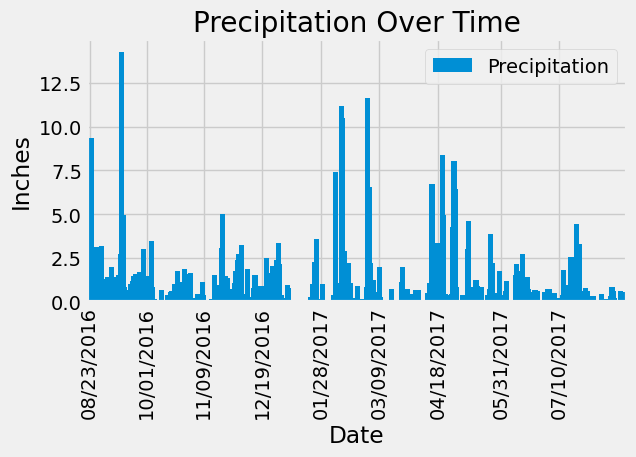

In [14]:
# Need to turn date back into a datetime measure to be able to add specific dates to the x-tick in the code
measurement_sort['date'] = pd.to_datetime(measurement_sort['date'])

# Group by date and sum the precipitation for each date
precipitation_plot = measurement_sort.groupby('date')['precipitation'].sum()

# Plot the data
ax = precipitation_plot.plot(kind="bar", legend=True, width=3.5)

# Set the labels
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation Over Time")
plt.legend(["Precipitation"])  # Use a list for legend entry

# Specify the dates you want on the x-axis
specific_dates = [
    '2016-08-23',
    '2016-10-01',
    '2016-11-09',
    '2016-12-19',
    '2017-01-28',
    '2017-03-09',
    '2017-04-18',
    '2017-05-31',
    '2017-07-10'
]

# Convert specific dates to datetime
specific_dates = pd.to_datetime(specific_dates)

# Get indices of specific dates in the precipitation_plot index
indices = [precipitation_plot.index.get_loc(date) 
           for date in specific_dates 
           if date in precipitation_plot.index]


# Set the x-ticks to the indices of the specific dates
ax.set_xticks(indices)

# Set tick labels; ensure the labels match the count of indices
ax.set_xticklabels(specific_dates.strftime('%m/%d/%Y'), rotation="vertical")


# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
stat_summary = measurement_sort[['precipitation']]
stat_summary.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Used Inspector to find all columns in the Station table
inspector = inspect(engine)
station_columns = inspector.get_columns('station')

for column in station_columns:
    print(column)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}


In [17]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations = session.query(func.count(station.id)).scalar()
number_of_stations

9

In [18]:
print(type(station))

<class 'sqlalchemy.orm.decl_api.DeclarativeMeta'>


In [19]:
# Design a query to find the most active stations
station_activity = session.query(
                    station.station,  # Select the station identifier
                    func.count(measurement.id).label('count')  # Count of entries for each station
).join(
                    measurement,  # Join with the measurement table
                    measurement.station == station.station  # Join on station
).group_by(
                    station.station  # Group by station to count rows per station
).order_by(
                    func.count(measurement.id).desc()  # Order by count in descending order
).all()  

# Print the results
for station_name, count in station_activity:
    print(f"{station_name}, {count}")

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Assign most active station to station id
station_id = 'USC00519281'

# Calculate the lowest, highest, and average temperature for the specified station
temperature_stats = session.query(
    func.min(measurement.tobs).label('low'),
    func.max(measurement.tobs).label('high'),
    func.avg(measurement.tobs).label('average')
).join(
    station,
    measurement.station == station.station
).filter(
    station.station == station_id
).one()

# print low, high, average
temperature_stats

(54.0, 85.0, 71.66378066378067)

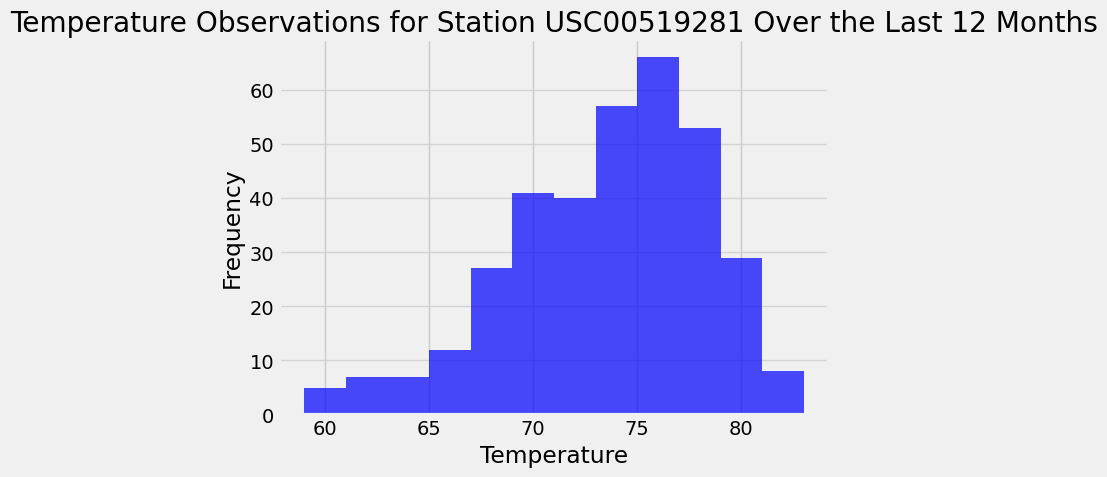

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query the last 12 months of temperature observation data for this station
temperature_data = session.query(measurement.tobs).filter(
    measurement.station == station_id,
    measurement.date >= one_year_ago_str, 
    measurement.date <= most_recent_date
).all()

# Convert the results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

# Plot the histogram of temperature observations
plt.figure(figsize=(6.5, 5))
plt.hist(temperature_df['tobs'], bins=12, color ='blue', alpha=0.7)
plt.title(f'Temperature Observations for Station {station_id} Over the Last 12 Months')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

# Close Session

In [22]:
# Close Session
session.close()